# Diode-catalyst coupled model

Formulated by Fountain et al. in DOI: 10.1038/ncomms13706 

Derivation can be found in this paper or in our publication (Supplementary information)


## Solar absorption efficiency

In [1]:
#General parameters

h=4.135e-15 #Planck constant, eV*s
c=299.8e06 #Speed of light, m/s
q_e=1.602e-19 #Electrin charge, C
kB=8.617e-05 #Boltzman constant, eV/K
T=293 #Temperature, K
RedPlank=6.582e-16 #Reduced Planck constant, eV*s
R=8.314 #Gas constant, J/(K*mol)
F=96485.3321 #Faraday's constant, C/mol

In [2]:
#Standard electrode potentials of reactions under investigation

import numpy as np

E_H2O=1.23
E_MetOH=0.016
E_Acetic=0.098
E_Acetaldehyde=0.052
E_Urea=0.37

E_reaction=np.array([E_H2O,E_MetOH, E_Acetic,E_Acetaldehyde,E_Urea])

In [3]:
#Read the standard solar spectra and create the working dataframe

import pandas as pd
AM_15G=pd.read_excel('AM 15G.xlsx')

In [4]:
#Calculate the photon flux (Equation S2)

AM_15G['photon_flux(lambda) m-2*s-1']=AM_15G['Global tilt  W*m-2*nm-1']*AM_15G['Wvlgth nm']*1e-9/h/q_e/c

In [5]:
#Calculate the band gaps 

AM_15G['Eg eV']=h*c/AM_15G['Wvlgth nm']/1e-9
Eg_range=AM_15G['Eg eV']

In [6]:
#Calculate the illuminated current 

from scipy import integrate
lamda=np.array(AM_15G['Wvlgth nm'])
photon_flux=np.array(AM_15G['photon_flux(lambda) m-2*s-1'])
illuminated_current=q_e*integrate.cumulative_trapezoid(y=photon_flux,x=lamda)
AM_15G['Illuminated current A*m-2']=pd.DataFrame(illuminated_current)
illuminated_current

array([7.22887951e-23, 4.64319768e-22, 9.67789454e-21, ...,
       6.89689801e+02, 6.89807210e+02, 6.89922605e+02], shape=(2001,))

In [7]:
#Calculate the Solar incident Power (Equation S1)

global_tilt=np.array(AM_15G['Global tilt  W*m-2*nm-1'])
solar_incident_power=integrate.simpson(y=global_tilt, x=lamda)
print(solar_incident_power)

1001.159375840659


In [8]:
#Calculate the reverse saturated (dark) current (Equation S11)

def integrand(E):
    return q_e/4/np.pi**2/RedPlank**3/c**2*E**2/(np.exp(E/kB/T)-1)

def I(Eg):
    return integrate.quad(integrand, Eg, np.inf)[0]

vec_explint=np.vectorize(I)

Eg_AM_15G=np.array(AM_15G['Eg eV'])
dark_current=vec_explint(Eg_AM_15G)
AM_15G['Dark current A*m-2']=pd.DataFrame(dark_current)
dark_current

C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\104350007.py:4: RuntimeWarning: overflow encountered in exp
  return q_e/4/np.pi**2/RedPlank**3/c**2*E**2/(np.exp(E/kB/T)-1)


array([5.52155979e-69, 7.52095770e-69, 1.02330282e-68, ...,
       2.05313674e+00, 2.08020611e+00, 2.10755781e+00], shape=(2002,))

## Idealistic case (no kinetic limitations)

### Study on selected organic oxidation reactions

In [9]:
#Parameters 

n_d=1 #Diod ideality factor

In [10]:
#Calculate SCE(Eg) for studied reactions

j_op_id = []

for a in range(len(Eg_range)):
    iL = AM_15G['Illuminated current A*m-2'][a]
    iD = AM_15G['Dark current A*m-2'][a]

    #Optimal current at which photovoltage equals to standard electrode potential
    j_fit_id = iL - iD*(np.exp(E_reaction/(kB*T)) - 1)   #Analytical solution can be obtained in idealized case

    #Cleaning of data
    j_op_id_i = np.where(iL - j_fit_id > 0, j_fit_id, iL)
    j_op_id_i = np.where(j_fit_id < 0, 0, j_fit_id)

    j_op_id.append(j_op_id_i)

j_op_id = np.array(j_op_id) 

etta_id = j_op_id * E_reaction / solar_incident_power * 100 #(Equation S13)

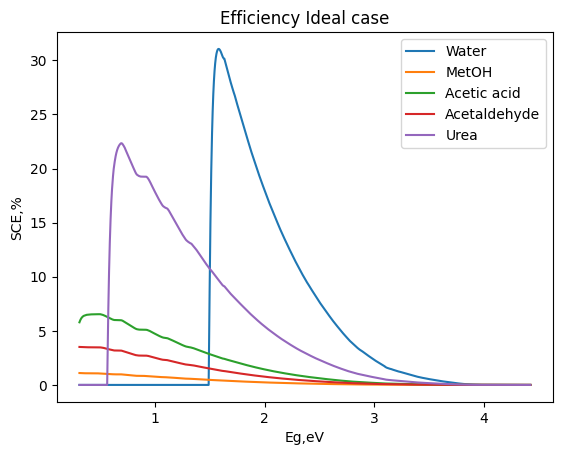

In [11]:
#Ideal case efficiency plot 

import matplotlib.pyplot as plt

Eg_range=AM_15G['Eg eV']
legend=['Water', 'MetOH', 'Acetic acid', 'Acetaldehyde', 'Urea']

plt.plot(Eg_range,etta_id,label=legend)
plt.title('Efficiency Ideal case')
plt.xlabel(r'Eg,''eV')
plt.ylabel(r'SCE,''%')
plt.legend(loc='best')
plt.show()

In [ ]:
# Write down calsulated data in excel file

col_names = ['H2O', 'MetOH', 'Acetic acid', 'Acetaldehyde', 'Urea']
ideal_case = pd.DataFrame(etta_id, columns=col_names)
ideal_case.insert(0, 'Bandgap, eV', Eg_range)
ideal_case.to_excel('Ideal_case.xlsx', index=False)

### Study on selected semiconductors

In [13]:
# Select semiconductors 

targets = np.array([3.2,2.4,2.8,1.5]) #we want to study TiO2/ZnO (Eg=3.2 eV), BiVO4 (Eg=2.4 eV), WO3 (Eg=2.8 eV) 
Eg=AM_15G['Eg eV'].to_numpy()
Eg_range_selected=np.abs(Eg[:, None] - targets[None, :]).argmin(axis=0)

In [14]:
#Calculate SCE(E0) for selected semiconductors

E_reaction_range=np.linspace(0,3,150)  #range of standard electrode potentials
curves_etta = []
curves_j = []

for a in Eg_range_selected:
    iL = AM_15G['Illuminated current A*m-2'][a]
    iD = AM_15G['Dark current A*m-2'][a]

    #Optimal current at which photovoltage equals to standard electrode potential
    j_fit_id = iL - iD*(np.exp(E_reaction_range/(kB*T)) - 1)   # Analytical solution can be obtained in idealized case

    # Cleaning of data 
    j_op_id_i = np.where(iL - j_fit_id > 0, j_fit_id, iL)
    j_op_id_i = np.where(j_fit_id < 0, 0, j_fit_id)
    etta = j_op_id_i * E_reaction_range / solar_incident_power * 100

    curves_j.append(j_op_id_i)
    curves_etta.append(etta)

curves_etta = np.array(curves_etta)

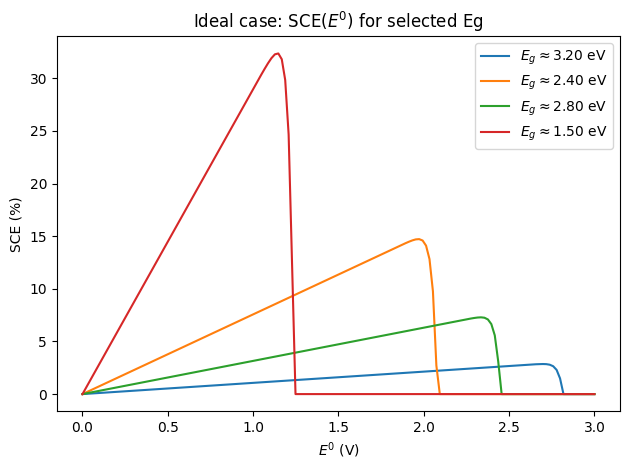

In [15]:
#Ideal case efficiency

for i, a in enumerate(Eg_range_selected):
    Eg_val = AM_15G.loc[a, 'Eg eV']
    plt.plot(E_reaction_range, curves_etta[i], label=fr'$E_g \approx {Eg_val:.2f}$ eV')

plt.xlabel(r'$E^{0}$ (V)')
plt.ylabel(r'SCE (%)')
plt.title('Ideal case: SCE($E^{0}$) for selected Eg')
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Write down calsulated data in excel file

col_names = ['TiO2', 'BiVO4', 'WO3', '1,5 eV']
selected_bandgaps = pd.DataFrame(curves_etta.T, columns=col_names)
selected_bandgaps.insert(0, 'Bandgap, eV', Eg_range)
selected_bandgaps.to_excel('Selected bandgaps.xlsx', index=False)

### Optimal $E^{0}$-$E_{g}$ relation

In [19]:
#Optimal dG-Eg relation

#Cut the whole dataframe to have Eg < 3 eV (just for better data presentation)
start = 255
stop = 2000      

sub = AM_15G.iloc[start:stop]

Eg_range = sub['Eg eV'].to_numpy()
IL = sub['Illuminated current A*m-2'].to_numpy()
ID = sub['Dark current A*m-2'].to_numpy()

E_reaction_grid = np.linspace(0.0, 2.0, 201)

n_Eg = len(Eg_range)
n_Er = len(E_reaction_grid)

etta_grid = np.zeros((n_Er, n_Eg))

for i, E_r in enumerate(E_reaction_grid):
    for j, Eg in enumerate(Eg_range):
        il_id = IL[j]
        id_id = ID[j]

        j_fit_id = il_id - id_id * (np.exp(E_r/(kB*T)) - 1) #analytical solution for optimal current density at which |V(j) - E_rxn|->0
        j_op = np.clip(j_fit_id, 0, il_id)
        etta = j_op * E_r / solar_incident_power * 100

        etta_grid[i, j] = etta

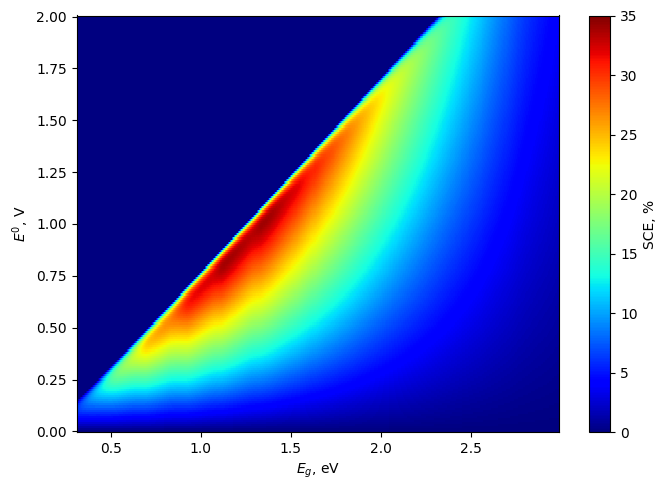

In [20]:
#Plot 2D efficiency map (idealistic case)

Eg_mesh, E_reaction_mesh = np.meshgrid(Eg_range, E_reaction_grid)

plt.figure(figsize=(7, 5))
pcm = plt.pcolormesh(Eg_mesh, E_reaction_mesh, etta_grid, shading='auto',
                     cmap='jet',
                     vmin=0, vmax=35)
plt.xlabel('$E_{g}$, eV')
plt.ylabel('$E^{0}$, V')
cbar = plt.colorbar(pcm)
cbar.set_label('SCE, %')
plt.tight_layout()
plt.savefig('Ideal_case_color_map.png')
plt.show()

In [25]:
# Analysis of abtined results

flat_idx = np.argmax(etta_grid)
i_max, j_max = np.unravel_index(flat_idx, etta_grid.shape)  

eta_max = etta_grid[i_max, j_max]
E_r_max = E_reaction_grid[i_max]
Eg_max = Eg_range[j_max]

print("Maximum SCE =", eta_max)
print('At Eg =', Eg_max)
print("At E0 =", E_r_max)

Maximum SCE = 34.01189661271792
At Eg = 1.3372955771305286
At E0 = 0.99


## Realistic case (kinetic limitations)

### Study on selected organic oxidation reaction

In [26]:
#Parameters

ERE=1e-06 # external radiative efficiency
j0_cat=10 # cathodic exchange current density, A/m2
r_s=0.1 # normalized series resistence
r_sh=10 # normalized shunt resistence
f_abs=0.9 # fraction of absorbed photons
n_d=1 # diode ideality factor
alfa=0.5 # electron transfer coefficient

In [27]:
#Exchange current density for the reactions under investigation experimentally estimated in the literature

j0_an_H2O=10e-04
j0_an_MetOH=10
j0_an_Acetic=7.9e-02
j0_an_Acetaldehyde=2.76e-04
j0_an_Urea=7.14e-02

j0_an_reaction=np.array([j0_an_H2O, j0_an_MetOH, j0_an_Acetic, j0_an_Acetaldehyde, j0_an_Urea])

In [28]:
#Number of electrons participating in the elementary step of electrochemical reaction

n_e_H2O=2
n_e_MetOH=2
n_e_Acetic=2
n_e_Acetaldehyde=2
n_e_Urea=2

n_e_reaction=np.array([n_e_H2O, n_e_MetOH, n_e_Acetic, n_e_Acetaldehyde, n_e_Urea])

In [29]:
#Calculate the photovoltage (as a function of semiconductor (bandgap) 
# and kinetic parameters of a reaction (number of transfering electrons and exchange curent density),
# j is current through the system)
#Equations S9, S10 and S12 

from scipy.optimize import brentq

def V_PEC(j, i, n_e, j0_an):
    iL, iD=f_abs*AM_15G['Illuminated current A*m-2'].iloc[i], AM_15G['Dark current A*m-2'].iloc[i]/ERE
    OCP=n_d*kB*T*np.log((iL-0)/iD+1)
    R_ch=OCP/(iL+iD)
    R_s=r_s*R_ch
    R_sh=r_sh*R_ch

    V_max=R_sh*(iD+iL-j)-j*R_s
    V_min=-1
    
    def f(V):
        return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s
    
    f_min = f(V_min)
    f_max = f(V_max)

    if np.isnan(f_min) or np.isnan(f_max) or f_min * f_max > 0:
        return np.nan  
    
    V_PV=brentq(f, V_min, V_max)

    V_an=R*T/alfa/n_e/F*np.arcsinh(j/2/j0_an) #Anodic overpotential
    V_cat=R*T/alfa/2/F*np.arcsinh(j/2/j0_cat) #Cathodic overpotential

    return V_PV-V_cat-V_an

In [30]:
#Calculate SCE for reactions under investigation over the whole band gap range

vec=np.vectorize(V_PEC)

def V_PEC_curve(j_array, i, n_e, j0_an):
    #returns i-V curve at a given semiconductor (fixed bangap) for a given reaction (fixed j0_an and n_e)
    return vec(j_array, i=i, n_e=n_e, j0_an=j0_an)   

def j_opt_for_i(i, E0, n_e, j0_an, n_points=1000):
    # calculate the optimum operating current for a given reaction on a given semiconductor

    #Calculate the maximum current and create the current range 
    iL, iD = AM_15G['Illuminated current A*m-2'].iloc[i], AM_15G['Dark current A*m-2'].iloc[i]
    i_lim=iL+iD

    j_grid = np.linspace(0, i_lim, n_points)
    V_curve = V_PEC_curve(j_grid, i, n_e, j0_an)

    V_min, V_max = np.nanmin(V_curve), np.nanmax(V_curve)
    #if the required potential can not be generated by semiconductor
    if  not (V_min <= E0 <= V_max):
        return np.nan

    idx = np.nanargmin(np.abs(V_curve - E0)) #optimal current is the one when photovoltage equals to standard electrode potential of the reaction
    return j_grid[idx]

j_opt=np.zeros((len(E_reaction), len(AM_15G['Eg eV'])))
etta=np.zeros((len(E_reaction), len(AM_15G['Eg eV'])))

#SCE is calculated for each reaction under investigation
for a in range(len(E_reaction)):
    E0=E_reaction[a]
    j0_an=j0_an_reaction[a]
    n_e=n_e_reaction[a]
    j_opt[a,:]=np.array([j_opt_for_i(k, E0, n_e, j0_an) for k in range(len(AM_15G['Eg eV']))])
    etta[a, :]=j_opt[a, :]*E0/solar_incident_power*100  #(Equation S13)


C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\1995818173.py:19: RuntimeWarning: invalid value encountered in log
  return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s
C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\2227483906.py:19: RuntimeWarning: All-NaN slice encountered
  V_min, V_max = np.nanmin(V_curve), np.nanmax(V_curve)
C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\1995818173.py:19: RuntimeWarning: divide by zero encountered in log
  return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s


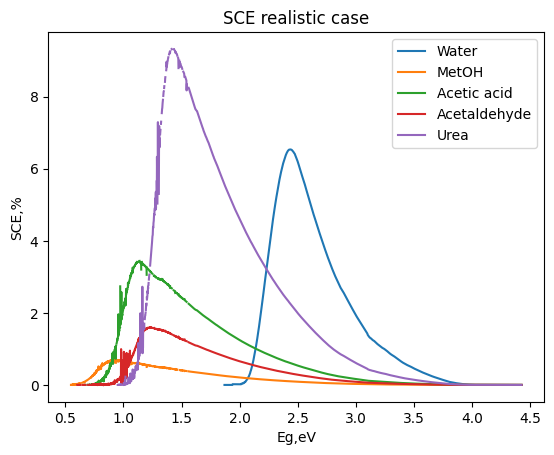

In [31]:
#Plot

Eg_range=AM_15G['Eg eV']
legend= ['Water', 'MetOH', 'Acetic acid', 'Acetaldehyde', 'Urea']
plt.plot(Eg_range, etta.T, label=legend)
plt.title('SCE realistic case')
plt.xlabel(r'Eg,''eV')
plt.ylabel(r'SCE,''%')
plt.legend(loc='best')
plt.show()

In [32]:
#Write the calculated data to the excel file

col_names = ['H2O', 'MetOH', 'Acetic acid', 'Acetaldehyde', 'Urea']
real_case= pd.DataFrame(etta.T, columns=col_names)
real_case.insert(0, 'Band gap, eV', Eg_range,)
real_case.to_excel('real_case.xlsx')

### 3D efficiency map (dependence of SCE on bandgap, reaction standard potential and exchange current density)

In [33]:
#Cut the dataframe to have bandgap values < 3 eV (for better data presentantion)

start = 255      # index of Eg=3 eV
stop = 2000      # len(AM_15G)

sub = AM_15G.iloc[start:stop]
sub = sub.reset_index(drop=True)
Eg_range=sub['Eg eV']

In [34]:
#redefine photovoltage function for the new dataframe

from scipy.optimize import brentq

def V_PEC(j, i):
    iL, iD=f_abs*sub['Illuminated current A*m-2'].iloc[i], sub['Dark current A*m-2'].iloc[i]/ERE
    OCP=n_d*kB*T*np.log((iL-0)/iD+1)
    R_ch=OCP/(iL+iD)
    R_s=r_s*R_ch
    R_sh=r_sh*R_ch

    V_max=R_sh*(iD+iL-j)-j*R_s
    V_min=-1
    
    def f(V):
        return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s
    
    f_min = f(V_min)
    f_max = f(V_max)

    if np.isnan(f_min) or np.isnan(f_max) or f_min * f_max > 0:
        return np.nan  
    
    V_PV=brentq(f, V_min, V_max)

    V_an=R*T/alfa/2/F*np.arcsinh(j/2/j0_an) #Anodic overpotential
    V_cat=R*T/alfa/2/F*np.arcsinh(j/2/j0_cat) #Cathodic overpotential

    return V_PV-V_cat-V_an

In [35]:
#Function to calculate i-V curve for a given bandgap (fixed Eg)

vec2=np.vectorize(V_PEC)
def V_PEC_curve(j_array, i):
    return vec2(j_array, i=i)

In [36]:
#Define function to calculate SCE as a function of standard electrode potential on a given semiconductor (fixed Eg) 

E_reaction_grid = np.linspace(0.0, 2.0, 101)   # set the reaction grid (we investigate reactions in the range from 0  to 2 V)

def j_opt_for_all_E(i, E_reaction_grid, n_points=300):
    
    #For a given Eg (index i) returns an array of optimal currents j_opt
    #for all standsrd potentials E0 from E_reaction_grid.
    
    # calculate j_lim for each Eg:
    iL = f_abs * sub['Illuminated current A*m-2'][i]
    iD = sub['Dark current A*m-2'][i] / ERE
    j_lim=iL+iD

    # current range from 0 to limiting
    j_grid = np.linspace(0.0, j_lim, n_points)

    # i-V curve for each Eg:
    V_curve = V_PEC_curve(j_grid, i)   

    j_opt = np.zeros_like(E_reaction_grid)

    for k, E0 in enumerate(E_reaction_grid):
        #if the required potential can not be generated by semiconductor
        if np.all(np.isnan(V_curve)) or (E0 > np.nanmax(V_curve)) or (E0 < np.nanmin(V_curve)):
            j_opt[k] = np.nan
        else:
            # search for minimum of |V(j) - E_rxn|, corresponding to an optimum current
            idx = np.nanargmin(np.abs(V_curve - E0))
            j_opt[k] = j_grid[idx]

    return j_opt  #array has the same size as E_reaction_grid

In [37]:
#Define function to calculate the 2D map SCE(Eg, E0) at a given exhcnage current density

def compute_eta_map_for_j0(j0_value, n_points=300):
    #Return the map SCE(Eg, E0) for a given j0_an= j0_value

    #Redefine the global parameter
    global j0_an
    j0_an = j0_value   

    etta_map = np.zeros((len(E_reaction_grid), len(Eg_range)))

    for ix in range(len(Eg_range)):
        j_opt_all = j_opt_for_all_E(ix, E_reaction_grid, n_points=n_points)
        etta_line = j_opt_all * E_reaction_grid / solar_incident_power * 100
        etta_map[:, ix] = etta_line

    #Mask NaN/inf
    etta_map = np.ma.masked_invalid(etta_map)
    return etta_map

#Selected exchange current density values (in A/m2)
j0_raw = [1e-4, 1e-2, 1e-8, 1e2] 
j0_labels = [r'$10^{-4}$', r'$10^{-2}$', r'$0$', r'$10^{2}$']  #z_axis labels

etta_maps = [compute_eta_map_for_j0(j0, n_points=300) for j0 in j0_raw]

C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\736822174.py:16: RuntimeWarning: invalid value encountered in log
  return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s
C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\736822174.py:16: RuntimeWarning: divide by zero encountered in log
  return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s


C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\848324802.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')
C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\848324802.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


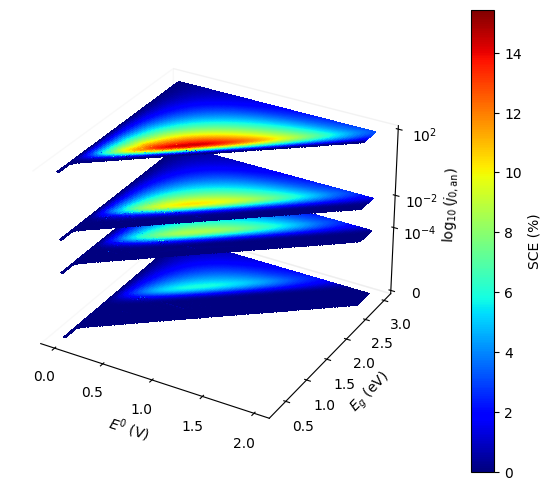

In [38]:
#Plot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# find a global maximum to create a uniform color scale
etta_max = max(np.nanmax(m) for m in etta_maps)
norm = Normalize(vmin=0, vmax=etta_max)
cmap = cm.get_cmap('jet')

X, Y = np.meshgrid(E_reaction_grid, Eg_range)   # X-axis is E0, Y-axis is Eg

for j0, etta in zip(j0_raw, etta_maps):
    # now SCE(E0, Eg), we want SCE(Eg, E0). Just for more convinient data presentation
    etta_plot = etta.T
    etta_plot = np.ma.masked_invalid(etta_plot)

    #logarithmic scale for exchange current densities
    z_level = np.log10(j0)
    Z = np.full_like(X, z_level, dtype=float)

    # create color scale
    fc = cmap(norm(etta_plot))
    if fc.ndim == 3 and fc.shape[0] == 4:
        fc = np.moveaxis(fc, 0, -1)

    surf = ax.plot_surface(
        X, Y, Z,
        rstride=1, cstride=1,
        facecolors=fc,
        linewidth=0,
        antialiased=False,
        shade=False
    )

    ax.contour(X, Y, Z, etta_plot,
                    levels=[5, 10, 15],
                colors='k', linewidths=1)

# Axis labels
ax.set_xlabel(r'$E^{0}$ (V)')
ax.set_ylabel(r'$E_g$ (eV)')
ax.set_zlabel(r'$\log_{10}(j_{0,\mathrm{an}})$')

# тики по оси z
z_ticks = []
for j0 in j0_raw:
    z_ticks.append(np.log10(j0))

ax.set_zticks(z_ticks)
ax.set_zticklabels(j0_labels)

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1)
cbar.set_label(r'SCE (%)')

ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticks([0, 0.5, 1, 1.5, 2])

plt.tight_layout()
plt.savefig('3D_plot.png')
plt.show()

In [40]:
# Analysis of the efficiency map

def _to_nan_array(a):
    if np.ma.isMaskedArray(a):
        return a.filled(np.nan)
    return np.asarray(a)

def find_max_etta(Eg_range, E_reaction_grid, j0_raw, etta_maps):
    per_layer = []

    for j0, etta in zip(j0_raw, etta_maps):
        etta = _to_nan_array(etta)

        # clean from +/-inf
        etta = np.where(np.isfinite(etta), etta, np.nan)

        # if the whole layer NaN — skip
        if np.all(np.isnan(etta)):
            per_layer.append({
                "SCE_max": np.nan, "j0_an": j0,
                "E0": np.nan, "Eg": np.nan
            })
            continue

        flat_idx = np.nanargmax(etta)                
        ix, iy = np.unravel_index(flat_idx, etta.shape)  

        per_layer.append({
            "SCE_max": float(etta[ix, iy]),
            "j0_an": j0,
            "E0": float(E_reaction_grid[ix]),
            "Eg": float(Eg_range[iy])
        })

    # global maximum among layers 
    valid = [r for r in per_layer if np.isfinite(r["SCE_max"])]
    global_best = max(valid, key=lambda r: r["SCE_max"]) if valid else None

    return global_best, per_layer


global_best, per_layer = find_max_etta(Eg_range, E_reaction_grid, j0_raw, etta_maps)

print("Global maximum:")
print(global_best)

print("\nFor each j0_an:")
for r in per_layer:
    print(r)

Global maximum:
{'SCE_max': 15.44318817233867, 'j0_an': 100.0, 'E0': 0.72, 'Eg': 1.4740463733650415}

For each j0_an:
{'SCE_max': 8.632028543852373, 'j0_an': 0.0001, 'E0': 0.62, 'Eg': 1.8641699248120298}
{'SCE_max': 11.153413680022375, 'j0_an': 0.01, 'E0': 0.52, 'Eg': 1.4740463733650415}
{'SCE_max': 5.91106582437097, 'j0_an': 1e-08, 'E0': 0.58, 'Eg': 2.062683860232945}
{'SCE_max': 15.44318817233867, 'j0_an': 100.0, 'E0': 0.72, 'Eg': 1.4740463733650415}


### Thermodinamics-kinetics interplay on a given semiconductor

In [41]:
#Find an index of a selected semiconductor 

target = 2.4 #We want study of BiVO4, it has bandgap of 2.4 eV


i_Eg = (sub['Eg eV'] - target).abs().idxmin()

In [51]:
#Calculate SCE(E0, j0_an) for a given semiconductor

E_reaction_grid = np.linspace(0.0, 2.0, 401)

def compute_eta_map_for_j0(j0_value, n_points=600):

    global j0_an
    j0_an = j0_value 

    etta_map = np.zeros(len(E_reaction_grid))
    j_opt_all = j_opt_for_all_E(i_Eg, E_reaction_grid, n_points=n_points)
    etta_line = j_opt_all * E_reaction_grid / solar_incident_power * 100
    etta_map = etta_line

    etta_map = np.ma.masked_invalid(etta_map)
    return etta_map

j0_an_vals=np.logspace(-20,8,400)
etta_maps = [compute_eta_map_for_j0(j0, n_points=300) for j0 in j0_an_vals]  

C:\Users\Катя\AppData\Local\Temp\ipykernel_1476\736822174.py:16: RuntimeWarning: invalid value encountered in log
  return V-kB*T*np.log((iL-j-(V+j*R_s)/R_sh)/iD+1)+j*R_s


In [52]:
# Merge in one dataset 

etta2d = np.vstack([np.asarray(m) for m in etta_maps])
etta2d = np.where(np.isfinite(etta2d), etta2d, np.nan)

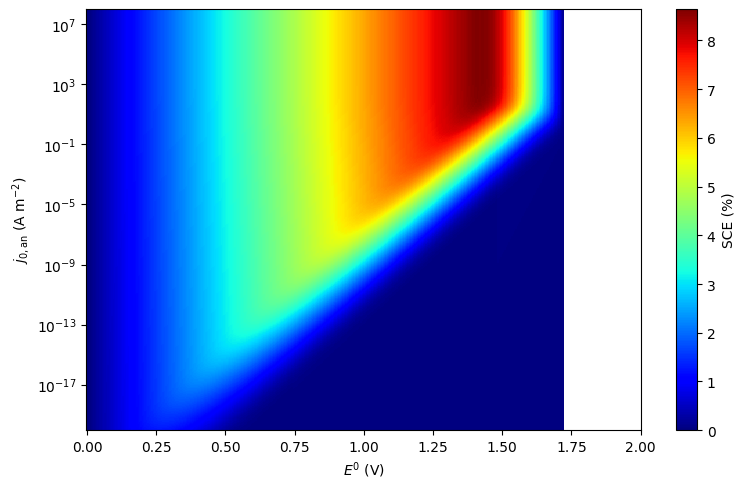

In [53]:
# Plot

X, Y = np.meshgrid(E_reaction_grid, j0_an_vals)

plt.figure(figsize=(8, 5))

pcm = plt.pcolormesh(
    X,
    Y,
    etta2d,
    shading='auto',
    cmap='jet',
    
)

plt.yscale('log')
plt.xlabel(r'$E^{0}$ (V)')
plt.ylabel(r'$j_{0,\mathrm{an}}$ (A m$^{-2}$)')

cbar = plt.colorbar(pcm)
cbar.set_label(r'SCE (%)')

plt.tight_layout()
plt.savefig('2D_plot_BiVO4.png')
plt.show()

# Reactive oxygen species study (Idealized case)

In [54]:
E_H2O=1.23 #Water
E_HO=2.73   #Hydroxyl radical formation
E_HClO=1.63 #Hypoclotire formation
E_O2=0.35   #Superoxide anion radical formation
E_SO4=2.43  #Sulfate radical formation

E_reaction_ROS=np.array([E_H2O,E_HO, E_HClO,E_O2, E_SO4])

In [60]:
#Calculate SCE(Eg) for selected ROS

j_op_id = []
Eg_range=AM_15G['Eg eV']

for a in range(len(Eg_range)):
    iL = AM_15G['Illuminated current A*m-2'][a]
    iD = AM_15G['Dark current A*m-2'][a]

    # Analytical solution for optimal current density at which |V(j) - E_rxn|->0
    j_fit_id = iL - iD*(np.exp(E_reaction_ROS/(kB*T)) - 1)

    # Cleaning the data
    j_op_id_i = np.where(iL - j_fit_id > 0, j_fit_id, iL)
    j_op_id_i = np.where(j_fit_id < 0, 0, j_fit_id)

    j_op_id.append(j_op_id_i)

j_op_id = np.array(j_op_id) 

etta_id = j_op_id * E_reaction_ROS / solar_incident_power * 100   #(Equation S13)

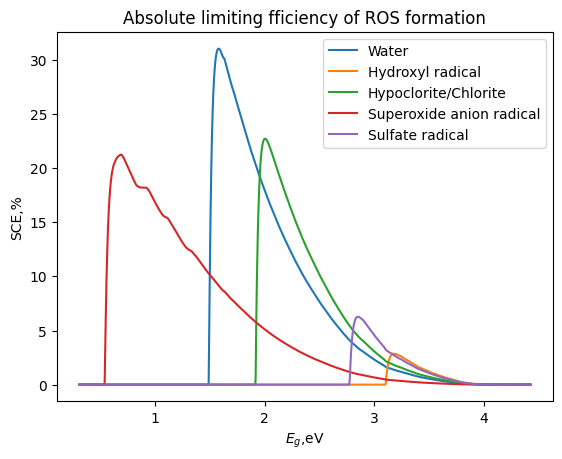

In [62]:
#Ideal case efficiency

legend=['Water' , 'Hydroxyl radical', 'Hypoclorite/Chlorite', 'Superoxide anion radical', 'Sulfate radical']
plt.plot(Eg_range, etta_id, label=legend)
plt.title('Absolute limiting fficiency of ROS formation')
plt.xlabel(r'$E_{g}$,''eV')
plt.ylabel(r'SCE,''%')
plt.legend(loc='best')
plt.show()

In [63]:
#Write calculated data in excel file

col_names = ['H2O', 'HO', 'HClO', 'O2', 'SO4']
df_ROS = pd.DataFrame(etta_id, columns=col_names)
df_ROS.insert(0, 'Bandgap, eV', Eg_range)
df_ROS.to_excel('ROS.xlsx', index=False)